✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
Grid Search: mejor F1-macro (CV) = 0.065 | mejor alpha = 0.5

=== Evaluación en PRUEBA ===
              precision    recall  f1-score   support

    NEGATIVO       0.20      0.25      0.22         4
     NEUTRAL       1.00      0.25      0.40         4
    POSITIVO       0.17      0.25      0.20         4

    accuracy                           0.25        12
   macro avg       0.46      0.25      0.27        12
weighted avg       0.46      0.25      0.27        12



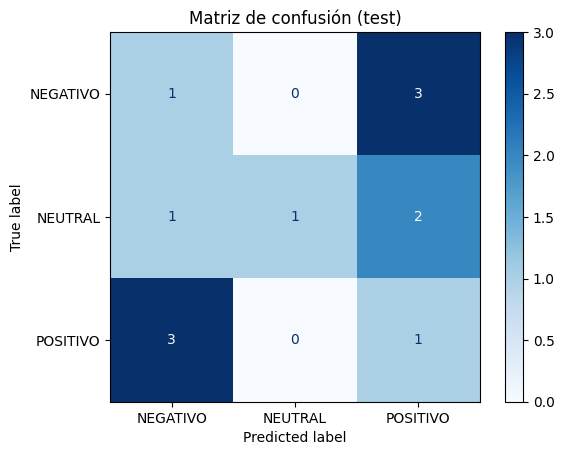


=== 1) TEXTO DE ENTRADA ===
Estoy aprendiendo mucho y me siento feliz

=== 2) PREPROCESAMIENTO (limpieza/normalización) ===
aprendiendo siento feliz

=== 3) ANÁLISIS LINGÜÍSTICO (tokens/lemmas/POS/NER) ===
Tokens: ['Estoy', 'aprendiendo', 'mucho', 'y', 'me', 'siento', 'feliz']
Lemas: ['estar', 'aprender', 'mucho', 'y', 'yo', 'sentir', 'feliz']
POS (palabra, etiqueta): [('Estoy', 'AUX'), ('aprendiendo', 'VERB'), ('mucho', 'ADV'), ('y', 'CCONJ'), ('me', 'PRON'), ('siento', 'VERB'), ('feliz', 'ADJ')]
Entidades NER: — (fallback sin NER)

=== 4) REPRESENTACIÓN NUMÉRICA (Top TF-IDF: w=palabra, c=caracter) ===
[('w:feliz', 0.7071067811865476),
 ('w:siento', 0.7071067811865476),
 ('c:ien', 0.24665671958877586),
 ('c:end', 0.2098983102871194),
 ('c: fel', 0.16291171472686564),
 ('c: feli', 0.16291171472686564),
 ('c:die', 0.16291171472686564),
 ('c:eli', 0.16291171472686564),
 ('c:eliz', 0.16291171472686564),
 ('c:endo', 0.16291171472686564),
 ('c:endo ', 0.16291171472686564),
 ('c:fel', 0.162

In [ ]:
# ==========================================================
# Sentimiento ES (negativo / neutral / positivo)
# spaCy (lemmas) + TF-IDF (word + char n-grams) + Naive Bayes
# Back-off robusto: tokens (1–2) + caracteres (3–5)
# Banda NEUTRAL por confianza (umbral=0.50) + Grid Search ligero (alpha)
# Modos: 'colab_form' | 'widgets' | 'input'
# Pipeline explicado paso a paso
# ==========================================================

# ---------- Configuración ----------
import os
os.environ.setdefault("THINC_BACKEND_FORCE_ARRAY_COPY", "1")  # evita bug thinc/numpy

try:
    import google.colab
    MODO_ENTRADA = "colab_form"   # Colab
except Exception:
    MODO_ENTRADA = "widgets"      # Cambia a "input" si no ves widgets

RUN_GRID = True                   # Grid Search ligero (solo nb__alpha)
UMBRAL_NEUTRAL = 0.50             # <-- umbral actualizado
SHOW_CONF_MATRIX = True

import warnings, time, re, numpy as np
warnings.filterwarnings("ignore")
from pprint import pprint

# ---------- spaCy con fallback ----------
def get_nlp_es():
    try:
        import spacy
        try:
            return spacy.load("es_core_news_sm")
        except Exception:
            import spacy.cli
            spacy.cli.download("es_core_news_sm")
            return spacy.load("es_core_news_sm")
    except Exception:
        import spacy
        return spacy.blank("es")

nlp = get_nlp_es()

# ---------- Stopwords/regex básicos ----------
STOP_ES = set("""
de la que el en y a los del se las por un para con no una su al lo como más pero sus le ya o este sí porque esta
entre cuando muy sin sobre también me hasta hay donde quien desde todo nos durante todos uno les ni contra otros
ese eso ante ellos e esto mí antes algunos qué unos yo otro otras otra él tanto esa estos mucho quienes nada muchos
cual poco ella estar estas algunas algo nosotros mi mis tú te ti tu tus ellas nosotras vosotros vosotras os mío mía míos mías
tuyo tuya tuyos tuyas suyo suya suyos suyas nuestro nuestra nuestros nuestras vuestro vuestra vuestros vuestras esos esas
estoy estás está estamos están estaré estará estarás estaremos estarán estaba estabas estaban estuve estuvo estuvimos
estuvieron sería serías seríamos serían soy eres somos son fui fue fuimos fueron seré serás será seremos serán
sería serías seríamos serían tengo tienes tiene tenemos tienen tuve tuviste tuvo tuvimos tuvieron tendría tendrías tendríamos tendrían
""".split())
URL_RE = re.compile(r"https?://\S+|www\.\S+")

# ---------- Dataset DEMO ----------
positivos = [
    "Me encanta este servicio","El soporte fue excelente","Estoy muy satisfecho",
    "La experiencia fue maravillosa","Muy contento con la compra","El curso estuvo genial",
    "Buena calidad y buen precio","Me gusta aprender cada día","Estoy progresando y eso me alegra",
    "El producto superó mis expectativas","Aprender me hace feliz","Estoy aprendiendo mucho",
    "Fue una atención impecable","Todo salió mejor de lo esperado",
    "La entrega fue rápida y sin problemas"
]
negativos = [
    "Odio este producto","La atención es pésima","Me siento frustrado con el resultado",
    "El envío llegó tarde y mal","Nunca volveré a comprar aquí","El curso fue un desastre",
    "La calidad es terrible","Estoy muy molesto con el servicio","Fue una pérdida de tiempo",
    "No recomendaría esto a nadie","La experiencia fue horrible","Estoy decepcionado",
    "Tuve muchos problemas con la compra","El soporte no respondió","Muy mala calidad para el precio"
]
neutrales = [
    "Hoy es lunes","Tengo que ir al trabajo","El paquete llegó","Estoy estudiando para el examen",
    "El clima está nublado","La reunión es a las 3","Necesito más información",
    "Estoy aprendiendo mucho sobre redes","Voy a revisar los documentos","Mañana es feriado",
    "El sistema se actualizó","Compré un libro ayer","Estoy leyendo el manual",
    "El pedido está en camino","Tenemos clase de NLP hoy"
]
textos  = positivos + negativos + neutrales
labels  = ([2]*len(positivos)) + ([0]*len(negativos)) + ([1]*len(neutrales))  # 0=NEG, 1=NEU, 2=POS
id2label = {0:"NEGATIVO 😡", 1:"NEUTRAL 😐", 2:"POSITIVO 😀"}

# ---------- Preprocesamiento robusto ----------
def limpiar_texto(texto: str) -> str:
    """Minúsculas, quita URLs, tokeniza sin tubería (make_doc),
    filtra stopwords/puntuación; usa lemma si existe."""
    texto = URL_RE.sub("", texto.lower())
    doc = nlp.make_doc(texto)  # NO activa tok2vec/ner (evita bugs)
    keep = []
    for t in doc:
        if t.is_space or t.is_punct:  continue
        if t.text in STOP_ES:         continue
        keep.append(getattr(t, "lemma_", None) or t.text)
    return " ".join(keep)

def analizar_linguistico(texto: str):
    """Intenta tubería completa; si falla, fallback a tokenización simple."""
    try:
        doc = nlp(texto)
        tokens = [t.text for t in doc if not t.is_space]
        lemmas = [t.lemma_ for t in doc if not t.is_space]
        pos    = [(t.text, getattr(t, "pos_", "")) for t in doc if not t.is_space]
        ents   = [(ent.text, ent.label_) for ent in getattr(doc, "ents", [])]
    except Exception:
        doc = nlp.make_doc(texto)
        tokens = [t.text for t in doc if not t.is_space]
        lemmas = [t.text for t in doc if not t.is_space]
        pos, ents = [], []
    return tokens, lemmas, pos, ents

# ---------- Pipeline: word + char n-grams ----------
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

word_vect = TfidfVectorizer(
    preprocessor=limpiar_texto,
    ngram_range=(1, 2),      # unigramas+bigramas
    min_df=1, max_df=1.0,
    sublinear_tf=True
)
char_vect = TfidfVectorizer(
    preprocessor=limpiar_texto,
    analyzer="char",
    ngram_range=(3, 5),      # 3-5 chars: robusto ante vocab pequeño/typos
    min_df=1, max_df=1.0,
    sublinear_tf=True
)

pipe = Pipeline([
    ("feats", FeatureUnion([("w", word_vect), ("c", char_vect)])),
    ("nb", MultinomialNB(alpha=1.0))
])

# ---------- Entrenamiento (Grid Search ligero opcional) ----------
X_train, X_test, y_train, y_test = train_test_split(
    textos, labels, test_size=0.25, random_state=42, stratify=labels
)

if RUN_GRID:
    grid = {'nb__alpha': [0.5, 1.0, 1.5]}
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    gs = GridSearchCV(pipe, grid, scoring='f1_macro', cv=cv, n_jobs=-1, verbose=0)
    gs.fit(X_train, y_train)
    pipe = gs.best_estimator_
    print("Grid Search: mejor F1-macro (CV) =", round(gs.best_score_, 3),
          "| mejor alpha =", gs.best_params_['nb__alpha'])
else:
    pipe.fit(X_train, y_train)

print("\n=== Evaluación en PRUEBA ===")
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred, target_names=["NEGATIVO","NEUTRAL","POSITIVO"]))
if SHOW_CONF_MATRIX:
    try:
        disp = ConfusionMatrixDisplay.from_predictions(
            y_test, y_pred, display_labels=["NEGATIVO","NEUTRAL","POSITIVO"], cmap="Blues"
        )
        plt.title("Matriz de confusión (test)")
        plt.show()
    except Exception:
        pass

# ---------- Utilidades ----------
def top_tfidf_union(texto: str, pipe, k: int = 12):
    """Top features para FeatureUnion (word + char) con prefijos."""
    feats_union = pipe.named_steps["feats"]
    vect_w = feats_union.transformer_list[0][1]
    vect_c = feats_union.transformer_list[1][1]
    X = feats_union.transform([texto])
    vec = X.toarray()[0]

    names_w = [f"w:{t}" for t in vect_w.get_feature_names_out()]
    names_c = [f"c:{t}" for t in vect_c.get_feature_names_out()]
    names   = names_w + names_c

    nz = vec.nonzero()[0]
    pares = [(names[i], float(vec[i])) for i in nz]
    pares.sort(key=lambda x: x[1], reverse=True)
    return pares[:k]

def predecir_con_banda(texto: str, umbral: float = UMBRAL_NEUTRAL):
    proba = pipe.predict_proba([texto])[0]        # [neg, neu, pos]
    pred  = int(np.argmax(proba))
    if proba[pred] < umbral:
        pred = 1  # NEUTRAL
    return pred, proba

# ---------- Paso a paso (como la infografía) ----------
def analizar_texto_paso_a_paso(texto: str):
    print("\n=== 1) TEXTO DE ENTRADA ===")
    print(texto)

    print("\n=== 2) PREPROCESAMIENTO (limpieza/normalización) ===")
    limpio = limpiar_texto(texto)
    print(limpio if limpio else "(quedó vacío tras filtrar)")

    print("\n=== 3) ANÁLISIS LINGÜÍSTICO (tokens/lemmas/POS/NER) ===")
    tokens, lemmas, pos, ents = analizar_linguistico(texto)
    print("Tokens:", tokens)
    print("Lemas:", lemmas)
    print("POS (palabra, etiqueta):", pos if pos else "— (fallback sin POS)")
    print("Entidades NER:", ents if ents else "— (fallback sin NER)")

    print("\n=== 4) REPRESENTACIÓN NUMÉRICA (Top TF-IDF: w=palabra, c=caracter) ===")
    pprint(top_tfidf_union(texto, pipe, k=12) or "—")

    print("\n=== 5) MODELO (Naive Bayes + banda neutra) ===")
    pred, proba = predecir_con_banda(texto, umbral=UMBRAL_NEUTRAL)
    print(f"Probabilidades -> NEG: {proba[0]:.2f} | NEU: {proba[1]:.2f} | POS: {proba[2]:.2f}")
    print(f"(Umbral NEUTRAL = {UMBRAL_NEUTRAL:.2f})")

    print("\n=== 6) SALIDA FINAL ===")
    print(f"➡ Resultado: {id2label[pred]}\n")

# ---------- Entrada: 'colab_form' | 'widgets' | 'input' ----------
if MODO_ENTRADA == "colab_form":
    #@title Analizar un texto (Colab Form)
    texto_usuario = "Estoy aprendiendo mucho y me siento feliz"  #@param {type:"string"}
    ejecutar = True  #@param {type:"boolean"}
    if ejecutar and texto_usuario.strip():
        analizar_texto_paso_a_paso(texto_usuario)
    else:
        print("Escribe un texto en el formulario y activa 'ejecutar'.")

elif MODO_ENTRADA == "widgets":
    try:
        try:
            from google.colab import output
            output.enable_custom_widget_manager()
        except Exception:
            pass
        import ipywidgets as widgets
        from IPython.display import display, clear_output
        caja = widgets.Text(placeholder="Escribe aquí el texto a analizar...",
                            description="Texto:", layout=widgets.Layout(width="90%"))
        btn = widgets.Button(description="Analizar", button_style="primary")
        out = widgets.Output()
        def on_click(_):
            with out:
                clear_output(wait=True)
                t = caja.value.strip()
                if not t: print("Por favor, escribe un texto.")
                else:    analizar_texto_paso_a_paso(t)
        display(caja, btn, out); btn.on_click(on_click)
        print("Modo widgets listo: escribe en la caja y pulsa 'Analizar'.")
    except Exception as e:
        print("No se pudieron cargar los widgets. Cambia MODO_ENTRADA a 'input'. Detalle:", e)

else:
    print("\nEscribe un texto para analizar (o SALIR para terminar).")
    while True:
        try:
            t = input("\n[TEXTO] ").strip()
        except EOFError:
            print("\nEntrada interrumpida. Fin."); break
        if not t:              print("⚠ Texto vacío. Intenta nuevamente."); continue
        if t.lower()=="salir": print("✅ Fin del análisis. ¡Gracias!"); break
        analizar_texto_paso_a_paso(t)
